## Prepare input files for Alaska rupture model
### 1. 3d velocity modle of Berg et al. 2020
### 2. thermal pressurization parameters
### 3. Initial prestress ratio constrained by fault coupling model


In [9]:
%matplotlib notebook

import numpy as np
from netCDF4 import Dataset
#from netCDF4 import Dataset
import pyproj
# import scipy 
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
print('done')

done


In [10]:
# write Dc proportion to locking coeffciient

## read in 1D velocity model.
# fin = Dataset('Bin&Roland/backward_slp_sample.nc','r')
fin = Dataset('Roland/backward_all_sample.nc','r')

print(fin.variables)

lat = fin.variables['y'][:]
lon = fin.variables['x'][:]

lock_max = 1.02815139294
# lock_max= 1.0

nx = len(lon)
ny = len(lat)
nz = 2

lock  = fin.variables['z'][:,:]
where_nan  = np.isnan(lock.data)
lock.data[where_nan] = 0.0

lock_sele =np.where(lock.data<0.6)
lock.data[lock_sele] = 0.1

## proj
lla = pyproj.Proj(proj="latlong", ellps="WGS84", datum="WGS84")
myproj = pyproj.Proj('+init=EPSG:5936')

xx,ydamp ,zdamp = pyproj.transform(lla, myproj,lon,lon-lon+54,lon, radians=False)
xdmap,yy,zdamp  = pyproj.transform(lla,myproj, lat-lat-158,lat,lat,radians=False)

### output for ASAGI format
fout = Dataset('bin2021_dc_bi4.nc','w',format='NETCDF4')
fout.createDimension('x',nx)
fout.createDimension('y',ny)
fout.createDimension('z',nz)
fout.createVariable('x','f8',('x',))
fout.createVariable('y','f8',('y',))
fout.createVariable('z','f8',('z',))
fout.variables['x'][:] = xx[:];
fout.variables['y'][:] = yy[:];
fout.variables['z'][:] = [10e3,-100e3];

vv = fout.createVariable('data','f4',('z','y','x'))
vv[0,:,:] = lock_max - lock.data+0.1
vv[1,:,:] = lock_max - lock.data+0.1

## check if locking greater than 0.5 or not

# print(vv[0,nn1[0][:]])
# vv[0,nn1[],nn1[1]] = 1.0
# nn2 = np.where(vv[1,:,:]>0.5)
# vv[1,nn2[0],nn2[1]] = 1.0

fout.close()


{'x': <class 'netCDF4._netCDF4.Variable'>
float64 x(x)
    long_name: x
    actual_range: [-162. -152.]
unlimited dimensions: 
current shape = (200,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'y': <class 'netCDF4._netCDF4.Variable'>
float64 y(y)
    long_name: y
    actual_range: [52. 59.]
unlimited dimensions: 
current shape = (140,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'z': <class 'netCDF4._netCDF4.Variable'>
float32 z(y, x)
    long_name: z
    _FillValue: nan
    actual_range: [0.00159046 1.0348177 ]
unlimited dimensions: 
current shape = (140, 200)
filling on}


/home/dli/anaconda3/envs/obspy/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_474820/1393841778.py:30: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xx,ydamp ,zdamp = pyproj.transform(lla, myproj,lon,lon-lon+54,lon, radians=False)
/tmp/ipykernel_474820/1393841778.py:31: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xdmap,yy,zdamp  = pyproj.transform(lla,myproj, lat-lat-158,lat,lat,radians=False)


In [7]:
print(nn1)


(array([0, 0, 0, ..., 1, 1, 1]), array([  0,   0,   0, ..., 139, 139, 139]), array([  0,   1,   2, ..., 197, 198, 199]))


In [11]:
## read in 3D velocity model.
fin = Dataset('/import/deadlock-data/dli/Alaska2021/Alaska.JointInversion-RF+Vph+HV-1.Berg.2020-nc4.nc')
# fin = Dataset('/import/freenas-m-05-seissol/dli/Alaska2021/velocity/Alaska-LFeng-2019-vsv-gamma.nc')
# fin = Dataset('/import/freenas-m-05-seissol/dli/Alaska2021/velocity/Alaska-CVM-AKAN2020-1.0.nc')
lat = fin.variables['latitude'][:]
lon = fin.variables['longitude'][:]
dep = fin.variables['depth'][:]

# sub domian selected
lonmax = -154
lonmin = -158
latmax = 58
latmin = 56

dy = np.where((lat>=56) & (lat<=58))
dx = np.where((lon<=-154) & (lon>=-158))
dz = np.where((dep<=200) & (dep>=5))
# first, to make the deeper portion with 1 km spacing

# index in longitude and latitude
nx1 = len(dx[0])
ny1 = len(dy[0])
nz = len(dz[0])


vp1 = fin.variables['vpfinal'][dz[0],dy[0],dx[0]]*1e3
vs1= fin.variables['vsfinal'][dz[0],dy[0],dx[0]]*1e3
rho1=fin.variables['rhofinal'][dz[0],dy[0],dx[0]]*1e3

print(vp1.shape)
print(dep[dz[0]])

(140, 21, 21)
[  5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.
  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.
  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.
  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102.
 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.]


In [12]:
# in geographic coordiantes
xgrid,ygrid = np.meshgrid(np.linspace(lonmin,lonmax,nx1),np.linspace(latmin,latmax,ny1))

print(dx[0].shape,dy[0].shape)
print(xgrid.shape)
# print(lat)

## proj
lla = pyproj.Proj(proj="latlong", ellps="WGS84", datum="WGS84")
myproj = pyproj.Proj('+init=EPSG:5936')
# 
xx,yy= pyproj.transform(lla, myproj,xgrid,ygrid,radians=False)

# xque = xx[20,:]
# yque = yy[:,20]


dx1 = np.floor((xx.max()-xx.min())/nx1)
dy1 = np.floor((yy.max()-yy.min())/ny1) 
print(xx.max(),xx.min(),dx1)
print(yy.max(),yy.min(),dy1)
# print(xque.shape,yque.shape)

# spatial 2d  interpolation
# xmax = 1850000
# xmin = 1260000
# ymax = -1700000
# ymin = -2240000

# zmin = -140000
# zmax = 2000


# forece dx = dy
xmax = int(xx.max())
xmin = xmax - nx1  *dx1 

ymax = int(yy.max())
ymin =  ymax - ny1 * dx1

xque = np.linspace(xmin,xmax,nx1)
yque = np.linspace(ymin,ymax,ny1)

print(xmin,xmax,ymin,ymax)

nx = 140e3
ny = 5e3

# uniform grids of every 10,000 m in Cartesian coordiantes
xgrid2,ygrid2 = np.meshgrid(np.linspace(xmin,xmax,nx1),np.linspace(ymin,ymax,ny1))

nx2 = nx1
ny2 = ny1 

vp2 = np.zeros((nz,ny2,nx2))
vs2 = np.zeros((nz,ny2,nx2))
rho2 = np.zeros((nz,ny2,nx2))

print(vp2.shape)

(21,) (21,)
(21, 21)
1745782.5175168721 1459291.428699806 13642.0
-1608890.2134350203 -1875687.389844099 12704.0
1459300.0 1745782 -1895372.0 -1608890
(140, 21, 21)


/home/dli/anaconda3/envs/obspy/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_3024208/1896467070.py:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xx,yy= pyproj.transform(lla, myproj,xgrid,ygrid,radians=False)


In [9]:
# iteration idep over z
for idep in range(0,nz):
    xnew = np.linspace(xmin,xmax,nx2)
    ynew = np.linspace(ymin,ymax,ny2)
    
    func = RectBivariateSpline(xque,yque, vp1[idep,:,:].transpose(), s=0)
    vnew = func(xnew, ynew)
    vp2[idep,:,:] = vnew.transpose()
    
    func = RectBivariateSpline(xque,yque, vs1[idep,:,:].transpose(), s=0)
    vnew = func(xnew, ynew)
    vs2[idep,:,:] = vnew.transpose()
    
    func = RectBivariateSpline(xque,yque, rho1[idep,:,:].transpose(), s=0)
    vnew = func(xnew, ynew)
    rho2[idep,:,:] = vnew.transpose()
    

In [136]:
# print(dx[0],dy[0])
# print(vp2[:,:,:].shape)
# print(dep[dz[0]])
# print(vs2[40,:,:])

In [246]:
### output for ASAGI format
fout = Dataset('/import/freenas-m-05-seissol/dli/Alaska2021/velocity/vel3d_deep_1.nc','w',format='NETCDF4')
fout.createDimension('x',nx2)
fout.createDimension('y',ny2)
fout.createDimension('z',nz)
fout.createVariable('x','f8',('x',))
fout.createVariable('y','f8',('y',))
fout.createVariable('z','f8',('z',))
fout.variables['x'][:] = xque
fout.variables['y'][:] = yque
fout.variables['z'][:] = -dep[dz[0][::-1]]*1e3;

mu = vs2**2*rho2
lamb = vp2**2*rho2-2*mu

material = np.dtype([('rho',np.float32),('mu',np.float32),('lambda',np.float32)])
data = fout.createCompoundType(material,'material')
#fout.createDimension('dd',(nz,ny,nx))
vv = fout.createVariable('data',data,dimensions=('z','y','x'))

ii=0
for k in range(0,nz):
    for j in range(0,ny2):
        for i in range(0,nx2):
            vv[k,j,i] = (rho2[nz-k-1,j,i],mu[nz-k-1,j,i],lamb[nz-k-1,j,i])
#            print(vv[k,j,i])
            ii += 1

fout.close()

In [177]:
print(-dep[dz[0][::-1]]*1e3)

[-144000.0 -143000.0 -142000.0 -141000.0 -140000.0 -139000.0 -138000.0
 -137000.0 -136000.0 -135000.0 -134000.0 -133000.0 -132000.0 -131000.0
 -130000.0 -129000.0 -128000.0 -127000.0 -126000.0 -125000.0 -124000.0
 -123000.0 -122000.0 -121000.0 -120000.0 -119000.0 -118000.0 -117000.0
 -116000.0 -115000.0 -114000.0 -113000.0 -112000.0 -111000.0 -110000.0
 -109000.0 -108000.0 -107000.0 -106000.0 -105000.0 -104000.0 -103000.0
 -102000.0 -101000.0 -100000.0 -99000.0 -98000.0 -97000.0 -96000.0
 -95000.0 -94000.0 -93000.0 -92000.0 -91000.0 -90000.0 -89000.0 -88000.0
 -87000.0 -86000.0 -85000.0 -84000.0 -83000.0 -82000.0 -81000.0 -80000.0
 -79000.0 -78000.0 -77000.0 -76000.0 -75000.0 -74000.0 -73000.0 -72000.0
 -71000.0 -70000.0 -69000.0 -68000.0 -67000.0 -66000.0 -65000.0 -64000.0
 -63000.0 -62000.0 -61000.0 -60000.0 -59000.0 -58000.0 -57000.0 -56000.0
 -55000.0 -54000.0 -53000.0 -52000.0 -51000.0 -50000.0 -49000.0 -48000.0
 -47000.0 -46000.0 -45000.0 -44000.0 -43000.0 -42000.0 -41000.0 -4000

-155.8 57.0


<IPython.core.display.Javascript object>


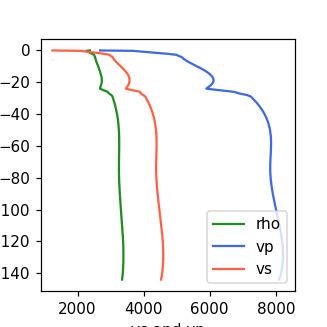

In [14]:
# rupture center (-158 57)
ndx=10
ndy=10

print(lon[dx[0][11]],lat[dy[0][10]])

rho=fin.variables['rhofinal'][:,dy[0],dx[0]]*1e3
vp = fin.variables['vpfinal'][:,dy[0],dx[0]]*1e3
vs= fin.variables['vsfinal'][:,dy[0],dx[0]]*1e3

fig,ax2=plt.subplots(ncols=1,nrows=1,figsize=(3,3))

ax2.plot(rho[:,ndy,ndx], -dep,'-',label='rho',color='forestgreen')
ax2.set_xlabel('rho')
ax2.set_ylabel('z km')
# ax1.set(ylim=(-200,0))
# ax2.legend()

ax2.plot(vp[:,ndy,ndx], -dep,'-',color='royalblue',label='vp')
# ax2.plot(vp_line2, -z,'-',color='b',label='vp')

ax2.set_ylabel('z km')

ax2.plot(vs[:,ndy,ndx], -dep,'-',color='tomato',label='vs')
# ax2.plot(vp_line2, -z,'-',color='b',label='vs')

ax2.set_xlabel('vs and vp')
ax2.set_ylabel('z km')
ax2.legend(loc=4)
# ax2.set(ylim=(-200,0))

plt.show()
plt.savefig('vel1d.png',dpi=200)



In [25]:
vdata2 = np.array([dep,rho[:,ndy,ndx],vp[:,ndy,ndx],vs[:,ndy,ndx]])
# print(vdata)

np.savetxt('velocity/1dvel_vpvs.txt',vdata2)


mu2 = vs[:,ndy,ndx]**2*rho[:,ndy,ndx]
lamb2 = vp[:,ndy,ndx]**2*rho[:,ndy,ndx]-2*mu2

vdata22 = np.array([dep*1000,mu2])
np.savetxt('velocity/1dvel_mu.txt',vdata22.transpose())


print(vdata22.transpose())

[[0.0000000e+00 3.6469105e+09]
 [2.5000000e+02 9.8284114e+09]
 [5.0000000e+02 1.0903710e+10]
 [7.5000000e+02 1.2035119e+10]
 [1.0000000e+03 1.3201612e+10]
 [1.2500000e+03 1.4409556e+10]
 [1.5000000e+03 1.5663771e+10]
 [1.7500000e+03 1.7090736e+10]
 [2.0000000e+03 1.8717528e+10]
 [2.2500000e+03 1.9874355e+10]
 [2.5000000e+03 2.1089028e+10]
 [2.7500000e+03 2.2048999e+10]
 [3.0000000e+03 2.2311746e+10]
 [3.5000000e+03 2.2771958e+10]
 [4.0000000e+03 2.3493251e+10]
 [4.5000000e+03 2.3929537e+10]
 [5.0000000e+03 2.4109824e+10]
 [6.0000000e+03 2.4819190e+10]
 [7.0000000e+03 2.5651380e+10]
 [8.0000000e+03 2.6602390e+10]
 [9.0000000e+03 2.7643089e+10]
 [1.0000000e+04 2.8725778e+10]
 [1.1000000e+04 2.9802752e+10]
 [1.2000000e+04 3.0854091e+10]
 [1.3000000e+04 3.1833285e+10]
 [1.4000000e+04 3.2710599e+10]
 [1.5000000e+04 3.3477177e+10]
 [1.6000000e+04 3.4143097e+10]
 [1.7000000e+04 3.4618270e+10]
 [1.8000000e+04 3.4892775e+10]
 [1.9000000e+04 3.4950427e+10]
 [2.0000000e+04 3.4782847e+10]
 [2.1000

In [253]:
# wirte layer velocity model in yaml file

with open('velocity_yaml.txt','w') as file1:
    file1.write("# this is a comment")
    for idep in range(0,len(vdata[1,:])):
        line = "        {}: [{},{},{}]\n".format(dep[idep]*1e3,rho[idep,ndy,ndx],mu2[idep],lamb2[idep])
        file1.write(line)
        

with open('velocity_yaml_ave.txt','w') as file1:
    file1.write("# this is a comment")
    for idep in range(0,len(vdata[1,:])):
        line = "        {}: [{},{},{}]\n".format(dep[idep]*1e3,rho[idep,ndy,ndx],mu2[idep],lamb2[idep])
        file1.write(line)

In [199]:
#calculate avarege density at depth h_i via the integral between z=0 and z=h_i: rho g h
# print(dep)
# print(rho1[:,ndy,ndx])
# ave = np.trapz(rho1[:,ndy,ndx],x=dep)

# initialize lithostatic loading using 0.025*rho_ave * g
ndepth = 156;
litho = np.zeros(ndepth)+25*9.8*2228

# print(ave) 
# depth in meter
for idepth in range(2,ndepth):
    litho[idepth]=np.trapz(rho[0:idepth,ndy,ndx]*9.8*1e3,x=dep[0:idepth])

print(litho)
data = np.array([dep[0:ndepth]*1e3,litho])

np.savetxt('lithostaticStress.txt',data.transpose())

[5.45860000e+05 5.45860000e+05 5.40323000e+06 1.08791030e+07
 1.63903780e+07 2.19381580e+07 2.75230560e+07 3.31458060e+07
 3.88084920e+07 4.45089080e+07 5.02390920e+07 5.59951240e+07
 6.17773680e+07 6.75863200e+07 7.92990400e+07 9.12119200e+07
 1.03335008e+08 1.15642824e+08 1.40749936e+08 1.66381840e+08
 1.92474336e+08 2.19011264e+08 2.46000464e+08 2.73384608e+08
 3.01071072e+08 3.28970688e+08 3.57000160e+08 3.85091360e+08
 4.13191392e+08 4.41256640e+08 4.69249856e+08 4.97134272e+08
 5.24879552e+08 5.52469504e+08 5.79898240e+08 6.07169664e+08
 6.34304896e+08 6.61496000e+08 6.88959040e+08 7.16628864e+08
 7.44432960e+08 7.72452608e+08 8.01028416e+08 8.30603840e+08
 8.60988736e+08 8.91707840e+08 9.22625856e+08 9.53734976e+08
 9.85021952e+08 1.01647398e+09 1.04807846e+09 1.07982413e+09
 1.11169958e+09 1.14369370e+09 1.17579610e+09 1.20799642e+09
 1.24028493e+09 1.27265203e+09 1.30508902e+09 1.33758925e+09
 1.37014490e+09 1.40274701e+09 1.43538790e+09 1.46805965e+09
 1.50075443e+09 1.533465

<IPython.core.display.Javascript object>


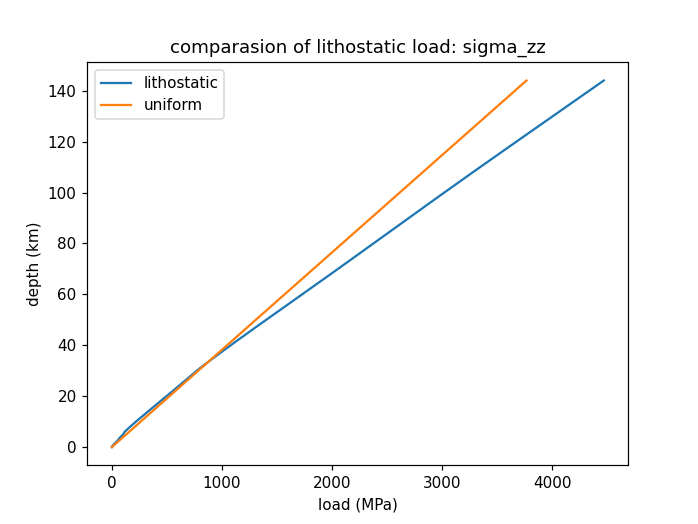

In [200]:
# print(dep)
# print(rho1[:,ndy,ndx])
uni_load = np.zeros(156)+2670

plt.figure()
plt.plot(litho/1e6,dep[0:156],label='lithostatic')
plt.plot(uni_load*9.8*dep[0:156]*1000/1e6,dep[0:156],label='uniform')
plt.legend()
plt.title('comparasion of lithostatic load: sigma_zz')
plt.xlabel('load (MPa)')
plt.ylabel('depth (km)')
plt.show()
plt.savefig('lithostaticStress.png',dpi=200)

3283.8033482142855


In [255]:
vdata = np.loadtxt('/import/freenas-m-05-seissol/dli/Alaska2021/velocity/1dvelocity_all.txt')
vdata2 = np.loadtxt('/import/freenas-m-05-seissol/dli/Alaska2021/velocity/1dvel_157_56.txt')
# print(vdata2.transpose())
vdata2 = vdata2.transpose()

<IPython.core.display.Javascript object>


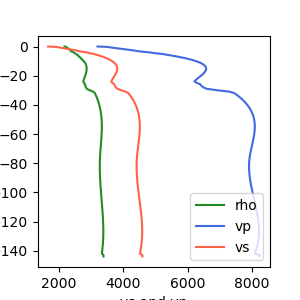

In [224]:
fig,ax2=plt.subplots(ncols=1,nrows=1,figsize=(3,3))

ax2.plot(vdata2[:,1], -vdata2[:,0],'-',label='rho',color='forestgreen')
ax2.set_xlabel('rho')
ax2.set_ylabel('z km')
# ax1.set(ylim=(-200,0))
# ax2.legend()

ax2.plot(vdata2[:,2], -vdata2[:,0],'-',color='royalblue',label='vp')
# ax2.plot(vp_line2, -z,'-',color='b',label='vp')

ax2.set_ylabel('z km')

ax2.plot(vdata2[:,3], -vdata2[:,0],'-',color='tomato',label='vs')
# ax2.plot(vp_line2, -z,'-',color='b',label='vs')

ax2.set_xlabel('vs and vp')
ax2.set_ylabel('z km')
ax2.legend(loc=4)

plt.show()
plt.savefig('vel1d_158_56.png',dpi=200)

# ax2.set(ylim=(-200,0))
